<a href="https://colab.research.google.com/github/ackq/learning-machine-learning/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Content.jpg to Content (1).jpg
Saving Style.jpg to Style (1).jpg
User uploaded file "Content.jpg" with length 86077 bytes
User uploaded file "Style.jpg" with length 138168 bytes


In [6]:
!ls

'Content (1).jpg'   Content.jpg   sample_data  'Style (1).jpg'	 Style.jpg


In [2]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 84kB/s 
     |████████████████████████████████| 3.1MB 35.5MB/s 
     |████████████████████████████████| 501kB 41.7MB/s 


2.0.0-beta1


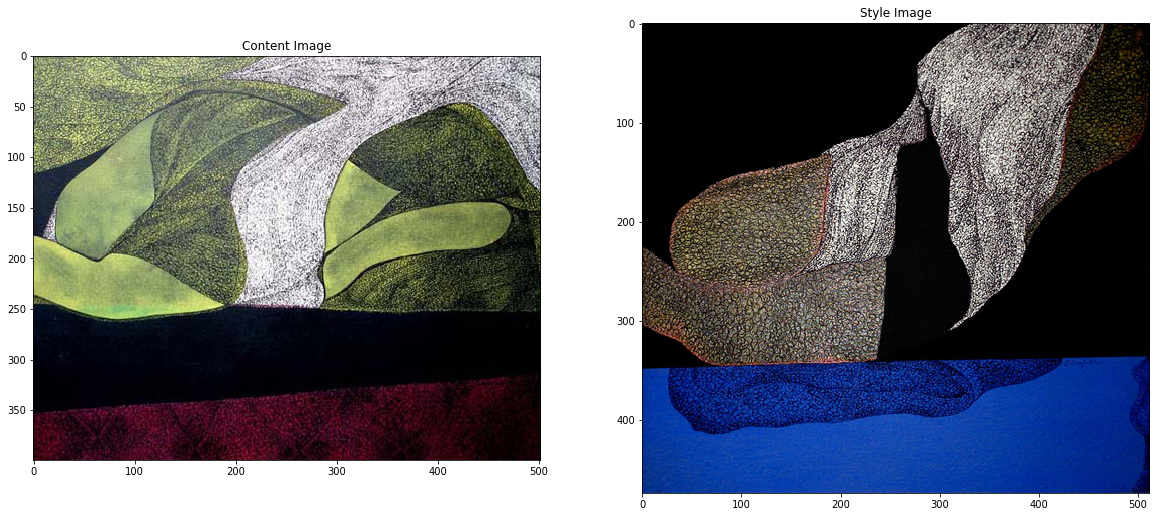

80142336/80134624 [==============================] - 3s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


W0724 12:38:15.012492 140460904019840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


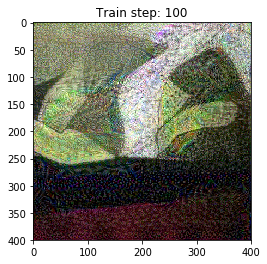

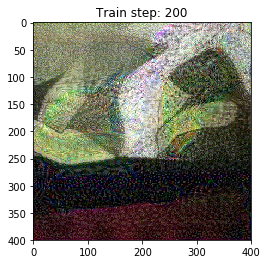

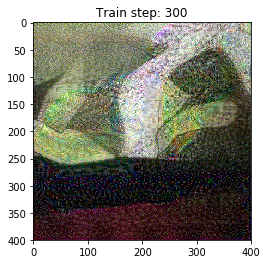

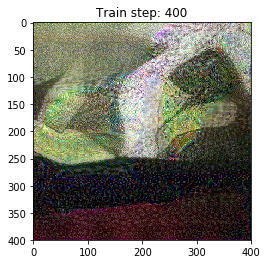

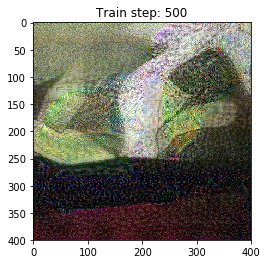

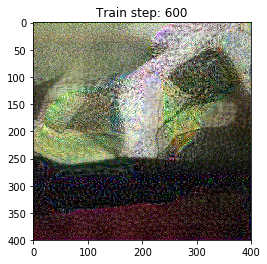

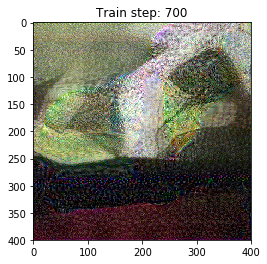

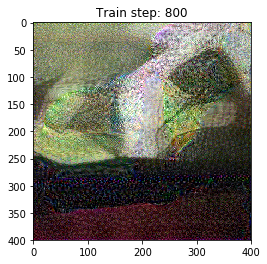

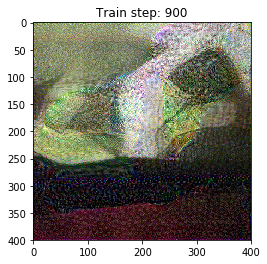

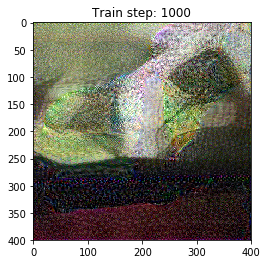

In [8]:
# Packages
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(7)

%matplotlib inline

print(tf.__version__)

# Load the content and style images
content = plt.imread('Content.jpg')
style = plt.imread('Style.jpg')

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()

def load_image(image):
  image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  # Shape -> (batch_size, h, w, d)
  img = img[tf.newaxis, :]
  return img

# Use load_image of content and style images
content = load_image('Content.jpg')
style = load_image('Style.jpg')

# Verify the shapes
content.shape, style.shape

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Print the layer names for convenience
for layer in vgg.layers:
  print(layer.name)

# Content layer
content_layers = ['block4_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']


num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def mini_model(layer_names, model):

  outputs = [model.get_layer(name).output for name in layer_names]

  model = Model([vgg.input], outputs)
  return model

# Gram matrix
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze(temp)
  fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
  result = tf.matmul(temp, temp, transpose_b=True)
  gram = tf.expand_dims(result, axis=0)
  return gram

class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  mini_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Scale back the pixel values
    inputs = inputs*255.0
    # Preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # Pass through the mini network
    outputs = self.vgg(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # Assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

# Note that the content and style images are loaded in
# content and style variables respectively
extractor = Custom_Style_Model(style_layers, content_layers)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

opt = tf.optimizers.Adam(learning_rate=0.02)

# Custom weights for style and content updates
style_weight=100
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.5,
                 'block4_conv1': 0.3,
                 'block5_conv1': 0.1}

# The loss function to optimize
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    # Normalize
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    # Normalize
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    # Extract the features
    outputs = extractor(image)
    # Calculate the loss
    loss = total_loss(outputs)
  # Determine the gradients of the loss function w.r.t the image pixels
  grad = tape.gradient(loss, image)
  # Update the pixels
  opt.apply_gradients([(grad, image)])
  # Clip the pixel values that fall outside the range of [0,1]
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

target_image = tf.Variable(content)

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(target_image)
  plt.imshow(np.squeeze(target_image.read_value(), 0))
  plt.title("Train step: {}".format(step))
  plt.show()